In [1]:
using Flux
using JLD
using PyPlot
import PyPlot.plot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = dataset.data
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.01 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
rdelta = 1e-3 # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, rdelta = rdelta, Beta = Beta, tracked = tracked)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 2))), 0.01, 0, 0.1262135922330097, 2000, 500, true, 50, 1, 0.001f0, 1.0f0, Dict{Any,Any}())

In [7]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, X, Y)
AnomalyDetection.evalloss(model, nX)

loss: 0.47454074189066886
reconstruction error: 0.4717004
KL: 0.17540769279003143

loss: 0.022906664460897445
reconstruction error: 0.012651874
KL: 1.3423211574554443

loss: 0.018912153746932746
reconstruction error: 0.007842196
KL: 1.2130417823791504

loss: 0.017793123312294483
reconstruction error: 0.00639398
KL: 1.3399667739868164

loss: 0.01760372458025813
reconstruction error: 0.004917525
KL: 1.2962106466293335

loss: 0.017372961174696683
reconstruction error: 0.0051664948
KL: 1.330397605895996



In [6]:
"""
	plot(model)

Plot the model losses.
"""
function plot(model::VAEmodel)
	# plot model loss
	if model.traindata == nothing
		println("No data to plot, set tracked = true before training.")
		return
	else
	    figure()
	    title("model loss, lambda = $(model.lambda)")
	    y1, = plot(model.traindata["loss"], label = "loss")
	    y2, = plot(model.traindata["reconstruction error"], label = "reconstruction error")
	    ax = gca()
	    ylabel("loss + reconstruction error")
	    xlabel("iteration")
	    
	    ax2 = ax[:twinx]()
	    y3, = plot(model.traindata["KLD"], label = "KLD", c = "g")
	    ylabel("KLD")
	    legend([y1, y2, y3], ["loss", "reconstruction error", "KLD"])
	    show()
	end
end

PyPlot.plot

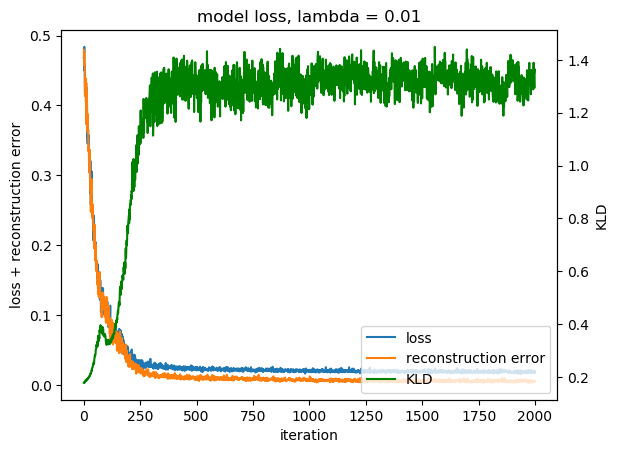

In [9]:
# plot model loss
plot(model)

In [10]:
model.traindata["KLD"]

2000-element Array{Float64,1}:
 0.177406
 0.177055
 0.178068
 0.180085
 0.178728
 0.179907
 0.183949
 0.183875
 0.186701
 0.185608
 0.187175
 0.185666
 0.187741
 ⋮       
 1.31528 
 1.29484 
 1.33817 
 1.29431 
 1.28826 
 1.29215 
 1.38926 
 1.32545 
 1.34761 
 1.35275 
 1.36588 
 1.29621 

In [30]:
model(nX)

Tracked 2×90 Array{Float64,2}:
 0.863892  0.830458  0.814471  0.839325  …  0.161654  0.0293317  0.0489067
 0.838873  0.839823  0.837918  0.842598     0.90319   0.998548   0.997371 

In [31]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mu(model, nX)

Tracked 2×90 Array{Float32,2}:
 -1.16255    -1.17033    -1.17673    …  1.18602    1.10462    1.09037  
 -0.0204396  -0.0174954  -0.0201667     0.0767602  0.0877462  0.0773273

In [58]:
AnomalyDetection.sigma(model, nX)

Tracked 2×90 Array{Float64,2}:
 0.979084  0.980247  0.978773  0.978404  …  0.975364  0.974028  0.969403
 0.390553  0.39098   0.392786  0.400731     0.296066  0.295871  0.298322

In [55]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float64,2}:
 -0.233029  -0.809909   1.28625   -0.24134  …  0.291209  -0.254444  -0.704517
 -1.40152   -0.815275  -0.236017  -1.1804      0.984927   0.866157   0.536782

In [35]:
# predict labels
model.M = 100 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 0
 1

In [36]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 10
  tn = 90
  fp = 0
  fn = 3
precision: 1.0
f1score: 0.8695652173913043
recall: 0.7692307692307693
false positive rate: 0.0
equal error rate: 0.11538461538461539

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 10
  tn = 90
  fp = 0
  fn = 3
precision: 1.0
f1score: 0.8695652173913043
recall: 0.7692307692307693
false positive rate: 0.0
equal error rate: 0.11538461538461539


In [43]:
using ScikitLearn.Utils: meshgrid

INFO: Recompiling stale cache file /home/vit/anaconda3/share/julia/site/lib/v0.6/ScikitLearn.ji for module ScikitLearn.


LoadError: LoadError: [91mDeclaring __precompile__(true) is only allowed in module files being imported.[39m
while loading /home/vit/anaconda3/share/julia/site/v0.6/ScikitLearn/src/ScikitLearn.jl, in expression starting on line 8

In [38]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).tracker.data
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

LoadError: [91mUndefVarError: meshgrid not defined[39m

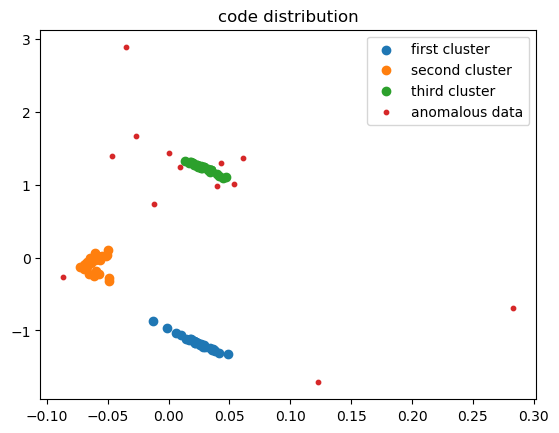

In [39]:
# what are the codes?
figure()
title("code distribution")
z1 = model.vae.encoder(X[:,1:30]).data
z2 = model.vae.encoder(X[:,31:60]).data
z3 = model.vae.encoder(X[:,61:90]).data
za = model.vae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()